In [93]:
import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler #as sampler
import model #as model
# import diffusionmap as dm
# import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
# from openmmtools.constants import kB

from pydiffmap import diffusion_map as dmpy
import helpers
import model



In [103]:


############################
# target temperature
T=500.0

T_target=300.0


dataName='TemporaryData_T500K'
folderName='/Users/zofia/github/DFM/'
methodName='std_500'

modelName='Dimer'

modnr = 10000

colective_variable = helpers.compute_radius
cv_name = 'Radius'

# results from this code will be saved here:
simulationFolder='/Users/zofia/github/DFM/TemporaryFigures/'+modelName+'/'+methodName

# load results from reference simulation already postprocessed
addReference=1
reference_folder = '/Users/zofia/github/DFM/TemporaryFigures/'+modelName+'/std_300'

### reference at 300K
# Raw:
# <Radius> = Quantity(value=1.7522397, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5599391188475216, unit=angstrom)
# Raw:
# <E> = Quantity(value=4.8909900846302508, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.1952283576218186, unit=kilojoule/mole)
# ->3.46 :)
#t 500:
# Raw:
# <Radius> = Quantity(value=2.1970608, unit=angstrom)
#
# Unbiased:
# <Radius> = Quantity(value=1.5851064100553285, unit=angstrom)
# Raw:
# <E> = Quantity(value=8.2463439643144607, unit=kilojoule/mole)
#
# Unbiased:
# <E> = Quantity(value=3.6909848345915366, unit=kilojoule/mole)
# ############################




In [ ]:
mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
# print (mdl.testsystem.positions)
# X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)





temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_raw=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')


integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')




newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)


10
3
2
Data length is 100


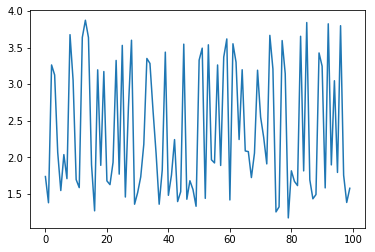

In [96]:
X_FT = helpers.loadData(folderName+dataName+'/'+modelName+'/'+methodName+'/Traj/*.h5', mdl.testsystem.topology)

X_FT=X_FT[::modnr]
print('Data length is '+repr(len(X_FT)))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

Get the target density at sampled data points
... might take a while ...
Done


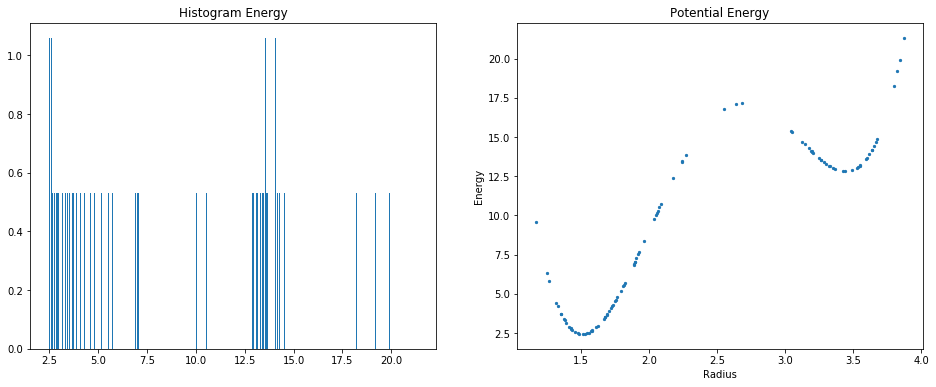

In [97]:

print('Get the target density at sampled data points')
print('... might take a while ...')

"""
target density: exp(-beta V(q)) : [V(q)] = kilojoule/mole, [beta] =  J/mol
"""

qTargetDistribution, E = helpers.computeTargetMeasure(X_FT, smpl)


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
cax = ax.hist(E, 1000, normed=True)
ax.set_title('Histogram Energy')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), E ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Energy')
ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/energy.png')

plt.show()

In [98]:

#### define rmsd metric


def myRMSDmetricPrecentered(arr1, arr2):
    """
    This is built under the assumption that the space dimension is 3!!!
    Requirement from sklearn radius_neighbors_graph: The callable should take two arrays as input and return one value indicating the distance between them.
     Input: One row from reshaped xyz trajectory as number of steps times nDOF
     Inside: Reshape back to md.Trajectory and apply md.rmsd as r=md.rmsd(X[i], X[j])
     Output: r
    """


    nParticles = len(arr1) / 3;
    assert (nParticles == int(nParticles))

    arr1 = arr1.reshape(int(nParticles), 3 )
    arr2 = arr2.reshape(int(nParticles), 3 )


    p1MD=md.Trajectory(arr1, mdl.testsystem.topology)
    p2MD=md.Trajectory(arr2,  mdl.testsystem.topology)

    d=md.rmsd(p1MD, p2MD, precentered=True, parallel=True)

    return d


/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: in rmsd(), precentered is ignored when atom_indices != None


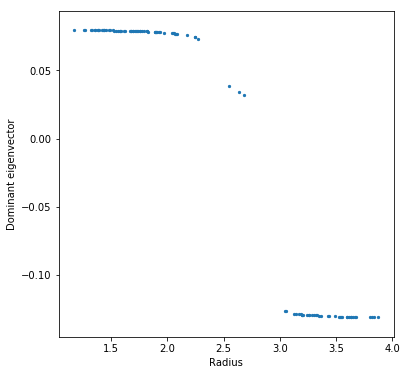

In [99]:
################ diffusion diffmaps

epsilon=0.01

Xresh=X_FT.reshape(X_FT.shape[0], X_FT.shape[1]*X_FT.shape[2])

mydmap = dmpy.DiffusionMap(n_evecs = 1, epsilon = epsilon, alpha = 0.5, k=2000, metric=myRMSDmetricPrecentered)
dmap = mydmap.fit_transform(Xresh)

P = mydmap.P
evals = mydmap.evals
evecs = mydmap.evecs

[evalsT, evecsT] = spsl.eigs(P.transpose(),k=1, which='LM')
phi = np.real(evecsT.ravel())


fig = plt.figure(figsize=(6,6))
plt.scatter(cv, evecs[:,0], s=5)
plt.xlabel('Radius')
plt.ylabel('Dominant eigenvector')

fig.savefig(simulationFolder+'/dominant_eigenvector.png')
plt.show()
#####


In [100]:

# estimated density by KDE
q_est = phi*mydmap.q
q_estNormalized = q_est/sum(q_est)

qTargetDistributionNormalized = qTargetDistribution/sum(qTargetDistribution)
print("Error on the density: "+repr(np.linalg.norm(q_estNormalized - qTargetDistributionNormalized,1)))

## compute weights

weight = qTargetDistribution/(mydmap.q)
qTargetDistributionNormalized=qTargetDistribution/np.sum(qTargetDistribution)

print('Sum weights is '+repr(np.sum(weight)))
print('mean weight is '+repr(np.mean(weight)))
print('sum weight is '+repr(np.sum(weight)))
print('max weight is '+repr(np.max(weight)))
print('min weight is '+repr(np.min(weight)))
print('Max error is '+repr(np.max(np.abs(qTargetDistributionNormalized-q_estNormalized))))
print('Mean error is '+repr(np.mean(np.abs(qTargetDistributionNormalized-q_estNormalized))))



Error on the density: 0.61890151830443818
Sum weights is 1.0208413364185587
mean weight is 0.010208413364185587
sum weight is 1.0208413364185587
max weight is 0.023759601029200515
min weight is 0.00093631790603594808
Max error is 0.012831213317352777
Mean error is 0.0061890151830443817


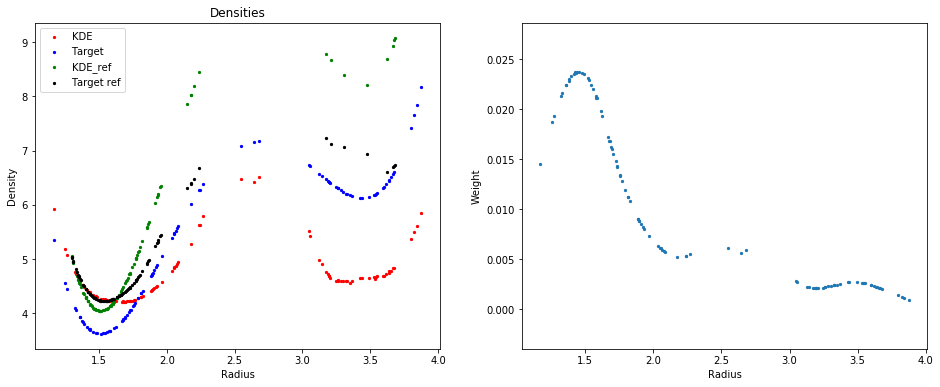

In [101]:

if addReference:
    q_estNormalized_ref = np.load(reference_folder+'/density_300K.npy')
    qTargetDistributionNormalized_ref = np.load(reference_folder+'/kde_300K.npy')
    cv_ref = np.load(reference_folder+'/cv_300K.npy')
    
else:
        np.save(reference_folder+'/density_300K.npy',  (qTargetDistributionNormalized))
        np.save(reference_folder+'/kde_300K.npy',  (q_estNormalized))
        np.save(reference_folder+'/cv_300K.npy',  cv)





### plot densities and weights


fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(cv, -np.log(q_estNormalized), s=5, c='r')
ax.scatter(cv, -np.log(qTargetDistributionNormalized), s=5, c='b')
if addReference:
    ax.scatter(cv_ref, -np.log(q_estNormalized_ref), s=5, c='g')
    ax.scatter(cv_ref, -np.log(qTargetDistributionNormalized_ref), s=5, c='k')
    ax.legend(['KDE','Target', 'KDE_ref', 'Target ref'])
else:
    ax.legend(['KDE','Target'])
ax.set_xlabel('Radius')
ax.set_ylabel('Density')

ax.set_title('Densities')


ax2 = fig.add_subplot(122)
cax2 = ax2.scatter(colective_variable(X_FT), weight  ,s=5 )
ax2.set_xlabel(cv_name)
ax2.set_ylabel('Weight')
#ax2.set_title('Potential Energy')

fig.savefig(simulationFolder+'/KDE_weight.png')


plt.show()


In [102]:

##### compute Averages

observable=cv

meanR=np.mean(observable)
meanRunbiased=np.mean(observable*weight)/np.mean(weight)

print('Raw:')
print('<'+cv_name+'> = '+repr(meanR*smpl.model.x_unit))

print('\nUnbiased:')
print('<'+cv_name+'> = '+repr(meanRunbiased*smpl.model.x_unit))

#compute mean energy

meanE=np.mean(E)
meanEunbiased=np.mean(E*weight)/np.mean(weight)

print('Raw:')
print('<E> = '+repr(meanE*smpl.model.energy_unit))

print('\nUnbiased:')
print('<E> = '+repr(meanEunbiased*smpl.model.energy_unit))

##############


Raw:
<Radius> = Quantity(value=2.3677268, unit=angstrom)

Unbiased:
<Radius> = Quantity(value=1.7572033442562822, unit=angstrom)
Raw:
<E> = Quantity(value=9.1855678910017016, unit=kilojoule/mole)

Unbiased:
<E> = Quantity(value=5.3768172693913083, unit=kilojoule/mole)


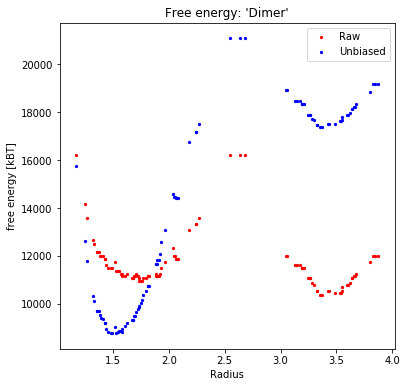

In [23]:
import imp
imp.reload(helpers)

width=0.1
cv=colective_variable(X_FT)
addReference=0

free_energy_raw=helpers.compute_free_energy(X_FT, cv, width=width, kBT=smpl.kT)
free_energy_unbiased=helpers.compute_free_energy(X_FT, cv, width=width, weights=weight, kBT=smpl.kT)

if(addReference):
    free_energy_raw_ref = np.load(reference_folder+'/free_energy.npy')
    free_energy_unbiased_ref = np.load(reference_folder+'/free_energy_unbiased.npy')
    cv_ref = np.load(reference_folder+'/cv_for_free_energy.npy')




fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(cv, free_energy_raw, s=5, c='r')
ax.scatter(cv, free_energy_unbiased, s=5, c='b')
if(addReference):
    ax.scatter(cv_ref, free_energy_raw_ref, s=5, c='g')
    ax.scatter(cv_ref, free_energy_unbiased_ref, s=5, c='k')
ax.set_xlabel(cv_name)
ax.set_ylabel('free energy [kBT]')
if(addReference):
    ax.legend(['Raw','Unbiased', 'Ref raw', 'Ref unbiased'])
else:
    ax.legend(['Raw','Unbiased'])
ax.set_title('Free energy: '+repr(modelName))

fig.savefig(simulationFolder+'/free_energy.png')

np.save(simulationFolder+'/free_energy_raw', free_energy_raw)
np.save(simulationFolder+'/free_energy_unbiased', free_energy_unbiased)
np.save(simulationFolder+'/radius_for_free_energy', cv)
plt.show()